## Automated user detection unsupervised

In [9]:
import pandas as pd
import ast

# Define the input and output file paths
input_file = 'all_domains_per_group.csv'  # Replace with your actual input file path
output_file = 'domain_info.csv'  # Replace with your desired output file path

# Read the CSV file, skipping any blank lines
df = pd.read_csv(input_file, header=None, names=['group', 'data'], skip_blank_lines=True)

# Drop any completely empty rows
df = df.dropna(how='all')

# Check the first few rows to understand the data format
print(df.head())

# Extract user_id and domains from the 'data' column
def extract_data(data):
    try:
        # Check if the data is a string (assuming valid entries are strings that can be evaluated)
        if isinstance(data, str) and data.startswith("("):
            # Convert the string representation of the tuple to an actual tuple
            user_id, domains = ast.literal_eval(data)
            # Sort domains alphabetically
            sorted_domains = ', '.join(sorted(domains))
            return user_id, sorted_domains
        else:
            return None, None
    except (ValueError, SyntaxError):
        return None, None

# Apply extraction function to the 'data' column
df[['user_id', 'domains']] = df['data'].apply(extract_data).apply(pd.Series)

# Drop the original 'group' and 'data' columns
df = df.drop(columns=['group', 'data'])

# Drop the first row
df = df.drop(index=0)

# Save the modified DataFrame to a new CSV file
df.to_csv(output_file, index=False)

print(f"Reshaped data saved to {output_file}")


   group                                               data
0      0                                                  1
1      0  ('1491069595045679104', {'ibtimes.com', 'newsc...
2      0  ('1426818534705831937', {'newsonair.gov.in', '...
3      0  ('1569343081975250946', {'newsonair.gov.in', '...
4      0  ('1517903845749567488', {'newsonair.gov.in', '...
Reshaped data saved to output_file.csv


In [16]:
import pandas as pd
import json
import os
import re

# Read user clusters file
df_clusters = pd.read_csv('user_clusters.csv')

# Get unique user IDs from the clusters file
cluster_users = df_clusters['user_id'].unique()

user_tweets_dir = 'user_tweets'
user_tweet_data = {}

# Regular expressions for extracting domains, hashtags, and mentions
domain_pattern = re.compile(r'https?://[a-zA-Z0-9./-]+')
hashtag_pattern = re.compile(r'#\w+')
mention_pattern = re.compile(r'@\w+')

for user_id in cluster_users:
    json_file_path = os.path.join(user_tweets_dir, f'user_{user_id}.json')
    
    if os.path.exists(json_file_path):
        with open(json_file_path, 'r') as file:
            tweet_data = json.load(file)
            
            # Initialize sets to hold extracted information
            user_tweet_data[user_id] = {
                'domains': set(),
                'hashtags': set(),
                'mentions': set(),
                'tweet_generators': set()
            }
            
            # Extract information from each tweet
            for tweet in tweet_data:
                tweet_text = tweet.get('Message', '')
                tweet_generator = tweet.get('Tweet Generator')
                
                # Extract domains
                domains = domain_pattern.findall(tweet_text)
                user_tweet_data[user_id]['domains'].update(domains)
                
                # Extract hashtags
                hashtags = hashtag_pattern.findall(tweet_text)
                user_tweet_data[user_id]['hashtags'].update(hashtags)
                
                # Extract mentions
                mentions = mention_pattern.findall(tweet_text)
                user_tweet_data[user_id]['mentions'].update(mentions)
                
                # Extract tweet generator
                if tweet_generator:
                    user_tweet_data[user_id]['tweet_generators'].add(tweet_generator)

# Create DataFrames for hashtags and mentions
hashtag_info = []
mention_info = []

for user_id, info in user_tweet_data.items():
    hashtag_info.append({'user_id': user_id, 'hashtags': ', '.join(sorted(info['hashtags']))})
    mention_info.append({'user_id': user_id, 'mentions': ', '.join(sorted(info['mentions']))})

# Convert to DataFrames
df_hashtags = pd.DataFrame(hashtag_info)
df_mentions = pd.DataFrame(mention_info)

# Save DataFrames to CSV files
df_hashtags.to_csv('hashtag_info.csv', index=False)
df_mentions.to_csv('mentions_info.csv', index=False)

print("Hashtag and mentions info saved to 'hashtag_info.csv' and 'mentions_info.csv'")


Hashtag and mentions info saved to 'hashtag_info.csv' and 'mentions_info.csv'


In [12]:
import pandas as pd

# Define the input file paths
clusters_file = 'user_clusters.csv'  # Replace with your actual input file path
domains_file = 'domain_info.csv'  # Replace with your actual input file path

# Function to get user-wise domains for a specific cluster
def get_user_wise_domains_for_cluster(cluster_number):
    # Read the CSV files
    clusters_df = pd.read_csv(clusters_file)
    domains_df = pd.read_csv(domains_file)

    # Ensure the data format is correct
    #print("Clusters Data:")
    #print(clusters_df.head())
    #print("Domains Data:")
    #print(domains_df.head())
    
    # Filter users belonging to the specified cluster
    cluster_users = clusters_df[clusters_df['cluster'] == cluster_number]['user_id'].tolist()
    
    if not cluster_users:
        print(f"No users found for cluster {cluster_number}")
        return
    
    # Filter domains information for those users
    cluster_domains_df = domains_df[domains_df['user_id'].isin(cluster_users)]
    
    # Organize domains by user_id
    user_domains = cluster_domains_df.groupby('user_id')['domains'].apply(lambda x: ', '.join(sorted(x, key=lambda d: d.lower()))).reset_index()
    
    # Print or save the result
    print(f"User-wise domains for cluster {cluster_number}:")
    print(user_domains)
    
    # Optionally save to CSV
    #user_domains.to_csv(f'user_wise_domains_cluster_{cluster_number}.csv', index=False)
    #print(f"Saved user-wise domains to user_wise_domains_cluster_{cluster_number}.csv")

# Example usage
cluster_number = int(input("Enter the cluster number: "))
get_user_wise_domains_for_cluster(cluster_number)


Enter the cluster number:  0


User-wise domains for cluster 0:
                user_id                                            domains
0   1523330437187129350  Dawn.com, Globalnews.ca, aa.com.tr, aajenglish...
1   1592192729005850625  Dawn.com, Globalnews.ca, aa.com.tr, aajenglish...
2   1615713931745718272  Dawn.com, Globalnews.ca, aa.com.tr, aajenglish...
3   1616087637466710018  Dawn.com, Globalnews.ca, aa.com.tr, abcnews.go...
4   1616316772671705088  Globalnews.ca, aa.com.tr, abcnews.go.com, alja...
5   1616318267379044352  Globalnews.ca, aa.com.tr, aajenglish.tv, abc.n...
6   1616320181764263937  Globalnews.ca, aa.com.tr, aajenglish.tv, abc.n...
7   1616320618022178819  Globalnews.ca, aa.com.tr, aajenglish.tv, abc.n...
8   1616321192318873602  Globalnews.ca, aa.com.tr, abcnews.go.com, abpl...
9   1616484342313947138  Dawn.com, Globalnews.ca, aa.com.tr, aajenglish...
10  1616706139982565380  Globalnews.ca, aa.com.tr, abc.net.au, abcnews....
11  1616707360231411712  Globalnews.ca, aa.com.tr, aajenglish.tv, a

In [14]:
import pandas as pd

# Define the input file path
domains_file = 'domain_info.csv'  # Replace with your actual input file path

def get_domain_counts(user_id1, user_id2):
    # Read the CSV file
    domains_df = pd.read_csv(domains_file)
    
    # Ensure the data format is correct
    #print("Domains Data:")
    #print(domains_df.head())
    
    # Filter domains for the two user IDs
    user1_data = domains_df[domains_df['user_id'] == user_id1]['domains']
    user2_data = domains_df[domains_df['user_id'] == user_id2]['domains']
    
    if user1_data.empty or user2_data.empty:
        print(f"One or both user IDs not found in the data.")
        return
    
    # Extract domain lists from the data
    user1_domains_list = set(user1_data.values[0].split(', '))
    user2_domains_list = set(user2_data.values[0].split(', '))
    
    # Find common domains
    common_domains = user1_domains_list.intersection(user2_domains_list)
    
    # Count domains
    count_common_domains = len(common_domains)
    count_user1_domains = len(user1_domains_list)
    count_user2_domains = len(user2_domains_list)
    
    print(f"User ID {user_id1}: {count_user1_domains} domains")
    print(f"User ID {user_id2}: {count_user2_domains} domains")
    print(f"Common domains between user IDs {user_id1} and {user_id2}: {count_common_domains}")
    
# Example usage
user_id1 = int(input("Enter the first user ID: "))
user_id2 = int(input("Enter the second user ID: "))
get_domain_counts(user_id1, user_id2)


Enter the first user ID:  1528972296643235840
Enter the second user ID:  1528989480442425344


User ID 1528972296643235840: 494 domains
User ID 1528989480442425344: 493 domains
Common domains between user IDs 1528972296643235840 and 1528989480442425344: 489


In [17]:
import pandas as pd

# Define the input file paths
domains_file = 'domain_info.csv'  # Replace with your actual input file path
hashtags_file = 'hashtag_info.csv'
mentions_file = 'mentions_info.csv'

def get_counts(file_path, user_id1, user_id2, data_type):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Filter data for the two user IDs
    user1_data = df[df['user_id'] == user_id1][data_type]
    user2_data = df[df['user_id'] == user_id2][data_type]
    
    if user1_data.empty or user2_data.empty:
        print(f"One or both user IDs not found in the {data_type} data.")
        return
    
    # Extract lists from the data
    user1_list = set(user1_data.values[0].split(', '))
    user2_list = set(user2_data.values[0].split(', '))
    
    # Find common items
    common_items = user1_list.intersection(user2_list)
    
    # Count items
    count_common_items = len(common_items)
    count_user1_items = len(user1_list)
    count_user2_items = len(user2_list)
    
    print(f"User ID {user_id1}: {count_user1_items} {data_type}")
    print(f"User ID {user_id2}: {count_user2_items} {data_type}")
    print(f"Common {data_type} between user IDs {user_id1} and {user_id2}: {count_common_items}")

# Example usage
user_id1 = int(input("Enter the first user ID: "))
user_id2 = int(input("Enter the second user ID: "))

print("\n--- Domain Counts ---")
get_counts(domains_file, user_id1, user_id2, 'domains')

print("\n--- Hashtag Counts ---")
get_counts(hashtags_file, user_id1, user_id2, 'hashtags')

print("\n--- Mentions Counts ---")
get_counts(mentions_file, user_id1, user_id2, 'mentions')


Enter the first user ID:  1528972296643235840
Enter the second user ID:  1528989480442425344



--- Domain Counts ---
User ID 1528972296643235840: 494 domains
User ID 1528989480442425344: 493 domains
Common domains between user IDs 1528972296643235840 and 1528989480442425344: 489

--- Hashtag Counts ---
User ID 1528972296643235840: 992 hashtags
User ID 1528989480442425344: 969 hashtags
Common hashtags between user IDs 1528972296643235840 and 1528989480442425344: 819

--- Mentions Counts ---
User ID 1528972296643235840: 367 mentions
User ID 1528989480442425344: 355 mentions
Common mentions between user IDs 1528972296643235840 and 1528989480442425344: 321


In [ ]:
import pandas as pd

# Define the input file paths
domains_file = 'domain_info.csv'
hashtags_file = 'hashtag_info.csv'
mentions_file = 'mentions_info.csv'
clusters_file = 'user_clusters.csv'

def get_user_ids_in_cluster(cluster_number):
    # Read the clusters file
    df = pd.read_csv(clusters_file)
    # Filter users belonging to the specified cluster
    users_in_cluster = df[df['cluster'] == cluster_number]['user_id']
    return users_in_cluster

def get_counts(file_path, user_id1, user_id2, data_type):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Filter data for the two user IDs
    user1_data = df[df['user_id'] == user_id1][data_type]
    user2_data = df[df['user_id'] == user_id2][data_type]
    
    if user1_data.empty or user2_data.empty:
        return None, None, None
    
    # Extract lists from the data
    user1_list = set(user1_data.values[0].split(', '))
    user2_list = set(user2_data.values[0].split(', '))
    
    # Find common items
    common_items = user1_list.intersection(user2_list)
    
    # Count items
    count_common_items = len(common_items)
    count_user1_items = len(user1_list)
    count_user2_items = len(user2_list)
    
    return count_common_items, count_user1_items, count_user2_items

def pairwise_similarity(cluster_number):
    # Get all user IDs in the specified cluster
    user_ids = get_user_ids_in_cluster(cluster_number)
    user_ids = user_ids.tolist()
    
    # Iterate through all pairs of user IDs in the cluster
    for i in range(len(user_ids)):
        for j in range(i + 1, len(user_ids)):
            user_id1 = user_ids[i]
            user_id2 = user_ids[j]
            
            print(f"\nComparing user ID {user_id1} with user ID {user_id2}:")
            
            # Domains
            print("\n--- Domain Counts ---")
            count_common_domains, count_user1_domains, count_user2_domains = get_counts(domains_file, user_id1, user_id2, 'domains')
            if count_common_domains is not None:
                print(f"User ID {user_id1}: {count_user1_domains} domains")
                print(f"User ID {user_id2}: {count_user2_domains} domains")
                print(f"Common domains between user IDs {user_id1} and {user_id2}: {count_common_domains}")
            else:
                print("Data not found for one or both users.")
            
            # Hashtags
            print("\n--- Hashtag Counts ---")
            count_common_hashtags, count_user1_hashtags, count_user2_hashtags = get_counts(hashtags_file, user_id1, user_id2, 'hashtags')
            if count_common_hashtags is not None:
                print(f"User ID {user_id1}: {count_user1_hashtags} hashtags")
                print(f"User ID {user_id2}: {count_user2_hashtags} hashtags")
                print(f"Common hashtags between user IDs {user_id1} and {user_id2}: {count_common_hashtags}")
            else:
                print("Data not found for one or both users.")
            
            # Mentions
            print("\n--- Mentions Counts ---")
            count_common_mentions, count_user1_mentions, count_user2_mentions = get_counts(mentions_file, user_id1, user_id2, 'mentions')
            if count_common_mentions is not None:
                print(f"User ID {user_id1}: {count_user1_mentions} mentions")
                print(f"User ID {user_id2}: {count_user2_mentions} mentions")
                print(f"Common mentions between user IDs {user_id1} and {user_id2}: {count_common_mentions}")
            else:
                print("Data not found for one or both users.")

# Example usage
cluster_number = int(input("Enter the cluster number: "))
pairwise_similarity(cluster_number)


Enter the cluster numbers (comma-separated):  8


Calculating similarities for clusters 8...


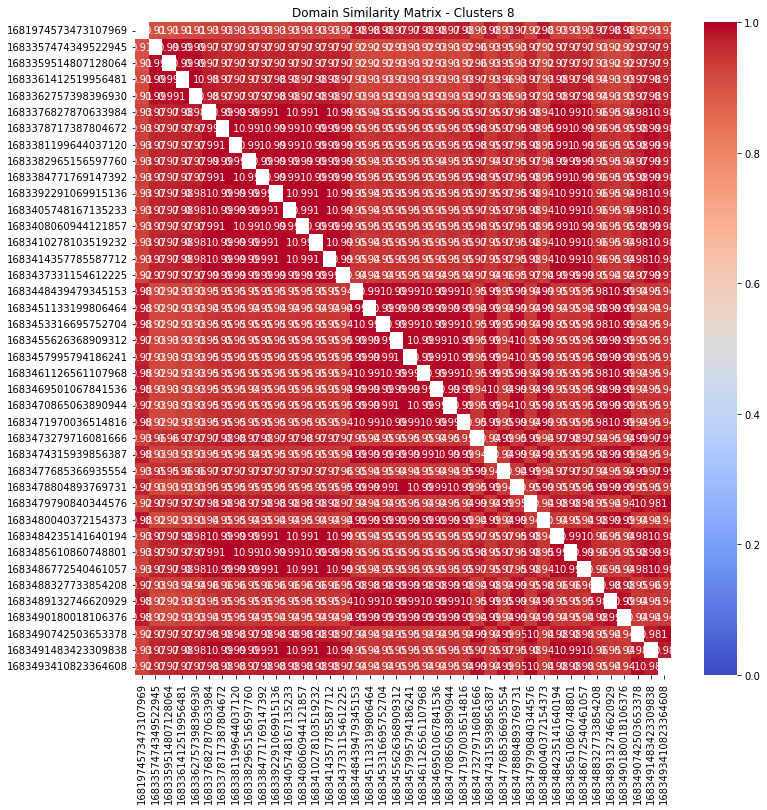

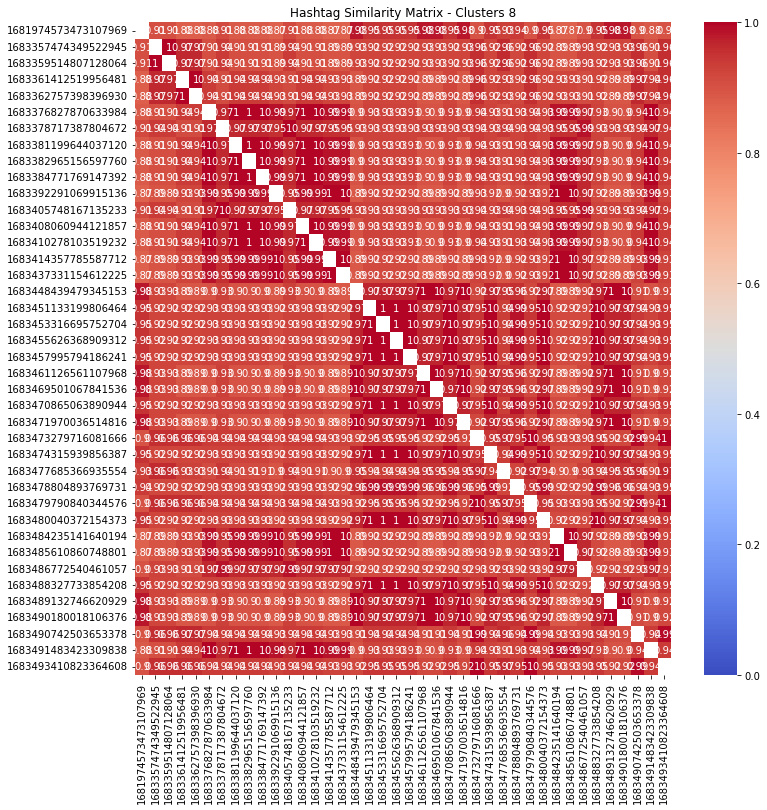

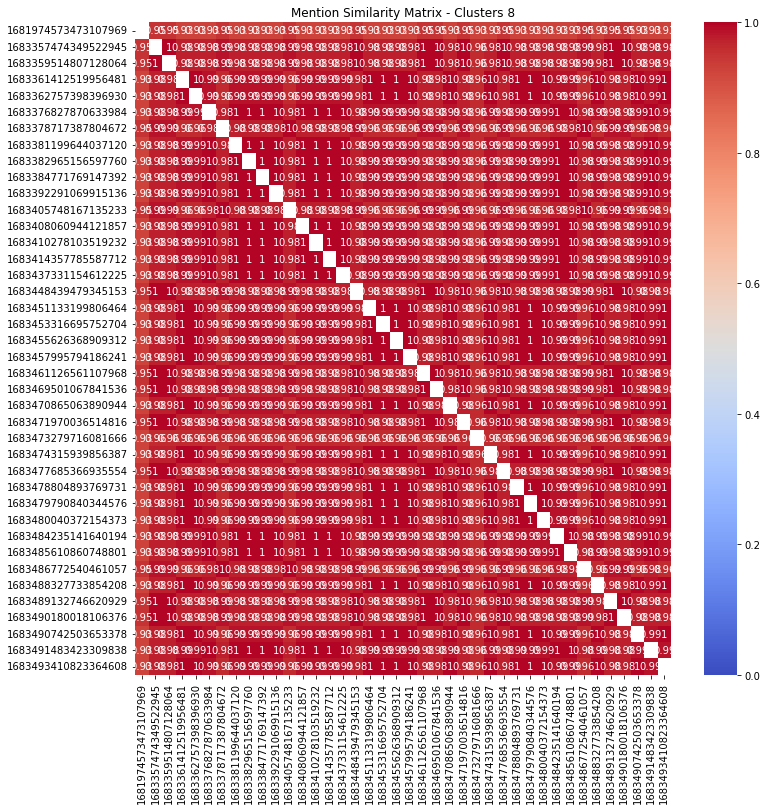

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the input file paths
domains_file = 'domain_info.csv'
hashtags_file = 'hashtag_info.csv'
mentions_file = 'mentions_info.csv'
clusters_file = 'user_clusters.csv'

def get_user_ids_in_clusters(cluster_numbers):
    df = pd.read_csv(clusters_file)
    users_in_clusters = df[df['cluster'].isin(cluster_numbers)]['user_id']
    return users_in_clusters

def get_counts(file_path, user_id, data_type):
    df = pd.read_csv(file_path)
    user_data = df[df['user_id'] == user_id][data_type]
    
    if user_data.empty:
        return None
    
    user_list = set(user_data.values[0].split(', '))
    return user_list

def calculate_similarity(user_list1, user_list2):
    common_items = user_list1.intersection(user_list2)
    count_common_items = len(common_items)
    return count_common_items / max(len(user_list1), len(user_list2))

def create_similarity_matrix(user_ids, file_path, data_type):
    n = len(user_ids)
    similarity_matrix = pd.DataFrame(index=user_ids, columns=user_ids, dtype=float)
    
    for i in range(n):
        for j in range(i + 1, n):
            user_id1 = user_ids[i]
            user_id2 = user_ids[j]
            
            user1_list = get_counts(file_path, user_id1, data_type)
            user2_list = get_counts(file_path, user_id2, data_type)
            
            if user1_list is not None and user2_list is not None:
                similarity = calculate_similarity(user1_list, user2_list)
                similarity_matrix.at[user_id1, user_id2] = similarity
                similarity_matrix.at[user_id2, user_id1] = similarity
    
    return similarity_matrix

def plot_similarity_matrix(matrix, title):
    plt.figure(figsize=(12, 12))
    sns.heatmap(matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar=True)
    plt.title(title)
    plt.show()

def visualize_clusters_similarity(cluster_numbers):
    user_ids = get_user_ids_in_clusters(cluster_numbers)
    user_ids = user_ids.tolist()
    
    if not user_ids:
        print("No users found for the given cluster numbers.")
        return
    
    print(f"Calculating similarities for clusters {', '.join(map(str, cluster_numbers))}...")
    
    # Create and plot similarity matrices for domains, hashtags, and mentions
    domain_matrix = create_similarity_matrix(user_ids, domains_file, 'domains')
    hashtag_matrix = create_similarity_matrix(user_ids, hashtags_file, 'hashtags')
    mention_matrix = create_similarity_matrix(user_ids, mentions_file, 'mentions')
    
    plot_similarity_matrix(domain_matrix, f'Domain Similarity Matrix - Clusters {", ".join(map(str, cluster_numbers))}')
    plot_similarity_matrix(hashtag_matrix, f'Hashtag Similarity Matrix - Clusters {", ".join(map(str, cluster_numbers))}')
    plot_similarity_matrix(mention_matrix, f'Mention Similarity Matrix - Clusters {", ".join(map(str, cluster_numbers))}')

# Example usage
cluster_numbers_input = input("Enter the cluster numbers (comma-separated): ")
cluster_numbers = [int(c.strip()) for c in cluster_numbers_input.split(",")]
visualize_clusters_similarity(cluster_numbers)

In [36]:
import json
import os
import pandas as pd
from datetime import datetime

# Define the input and output paths
blocdate_dir = 'blocdate'
output_csv = 'week_vector_output.csv'

# Initialize an empty list to store the data
user_data = []

# Create a list of all the days in 2023
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d')
days_in_2023 = [(start_date + pd.Timedelta(days=i)).strftime('%Y-%m-%d') for i in range(364)]

# Iterate over all the JSON files in the blocdate directory
for json_file in os.listdir(blocdate_dir):
    if json_file.endswith('.json'):
        # Load each JSON file
        json_file_path = os.path.join(blocdate_dir, json_file)
        with open(json_file_path, 'r') as file:
            data = json.load(file)
        
        # Initialize a vector for each user, one entry per day (364 days)
        week_vector = [0] * 364
        
        # Extract user ID and screen name
        user_id = data.get('user_id', None)
        screen_name = data.get('screen_name', None)
        
        # Extract bloc_data (which contains the tweet counts)
        bloc_data = data.get('bloc_data', {})
        
        # Fill in the tweet counts into the appropriate days
        for week_data in bloc_data.values():
            for date, count in week_data.items():
                if date in days_in_2023:
                    index = days_in_2023.index(date)  # Find the index corresponding to the day
                    week_vector[index] = count
        
        # Convert the week vector to a single array-like string
        week_vector_str = ','.join(map(str, week_vector))
        
        # Append the user's data (screen_name, user_id, and the array vector) to the user_data list
        user_data.append([user_id, screen_name, week_vector_str])

# Convert the data to a DataFrame and save it to a CSV file
df = pd.DataFrame(user_data, columns=['user_id', 'screen_name', 'week_vector'])
df.to_csv(output_csv, index=False)

print(f"Week vectors saved to {output_csv}")


Week vectors saved to week_vector_output.csv


In [ ]:
import json

# Specify the path to your JSON file
json_file_path = 'blocdate/_NehaRajput_bloc_data_2023_sorted.json'

# Load and print the structure of the first element of the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)
    print(json.dumps(data, indent=4, sort_keys=True))  # Pretty-print the structure


In [7]:
import pandas as pd

# Define the input CSV path (from previous step)
input_csv = 'filtered_week_vector_output.csv'
output_csv = 'auto_users.csv'

# Load the data
df = pd.read_csv(input_csv)

# Group users by their week_vector and reset index to get a clean DataFrame
grouped = df[['week_vector', 'user_id', 'screen_name']]

# Add a column for group_id (just an incremental index for each group)
grouped['group_id'] = grouped['week_vector'].astype('category').cat.codes + 1

# Save the grouped data to a new CSV
grouped.to_csv(output_csv, index=False)

# Show a sample of the grouped data
print(grouped.head())

print(f"Grouped users saved to {output_csv}")


                                         week_vector              user_id  \
0  0,0,0,0,0,0,0,0,0,0,0,7,4,0,0,4,4,4,4,4,1,1,4,...  1613397196250152960   
1  1,5,3,3,5,3,1,1,3,4,3,4,4,0,0,4,4,4,4,4,1,1,4,...  1564254887571259393   
2  1,5,3,3,5,4,1,1,3,4,2,4,4,0,0,4,4,4,4,4,1,1,4,...  1510137352231874564   
3  1,5,3,3,5,3,1,1,3,4,2,4,4,0,0,4,4,4,4,4,1,1,3,...  1533719237109264384   
4  1,5,3,3,4,3,1,1,3,4,3,4,4,0,0,4,4,4,4,4,1,1,4,...  1510523393010851840   

  screen_name  group_id  
0     0Malhun       240  
1  0Syedamina       454  
2    0_aadeel       466  
3    0_abinav       451  
4    0_ishaan       438  
Grouped users saved to auto_users.csv


/local_scratch/pbs.2808057.pbs02/ipykernel_573649/2651543085.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
import pandas as pd

# Define the path to the CSV file
#auto_users_file = 'auto_users.csv'
auto_users_file = 'merged_group_info.csv'

# Load the grouped data
grouped_df = pd.read_csv(auto_users_file)

# Count the number of users in each group
user_counts = grouped_df.groupby('group_id')['user_id'].count().reset_index()

# Rename columns for clarity
user_counts.columns = ['group_id', 'user_count']

# Save the DataFrame to an HTML file
html_file = 'user_counts.html'
user_counts.to_html(html_file, index=False)

# Display a message with the file path
print(f"DataFrame saved to {html_file}. Open this file in a browser to view the full contents.")


DataFrame saved to user_counts.html. Open this file in a browser to view the full contents.


Enter the cluster numbers to visualize (comma-separated):  2


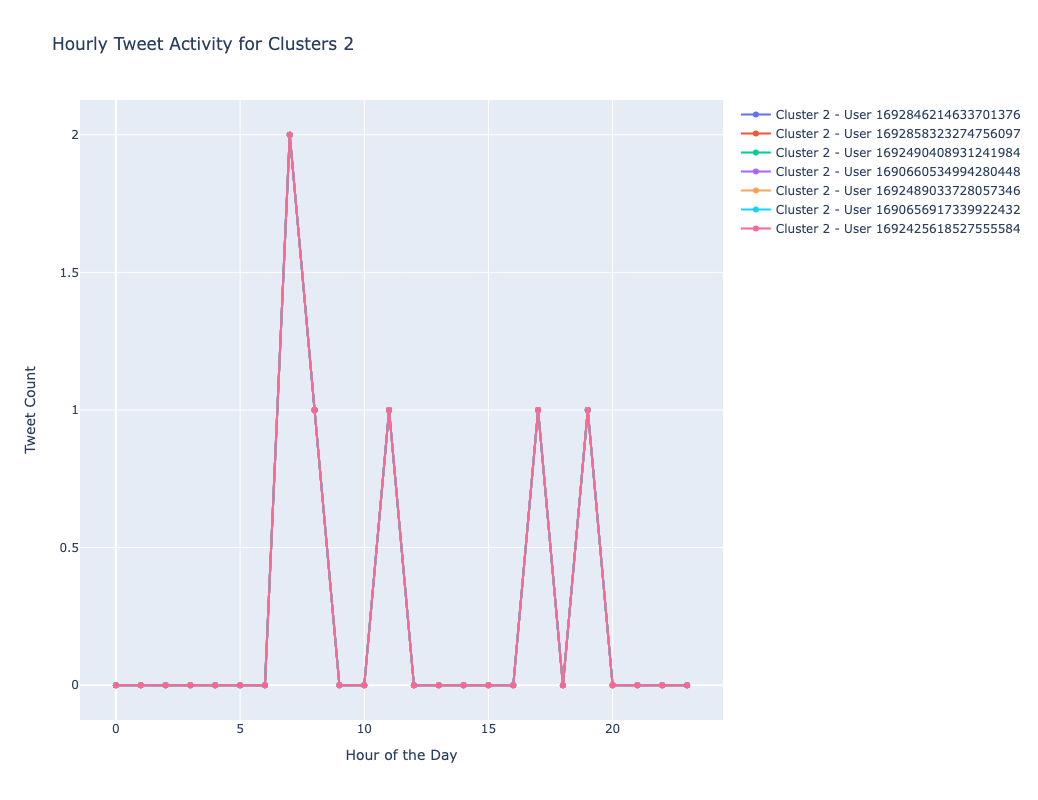

In [1]:
import json
import os
import pandas as pd
from dateutil.parser import isoparse
import plotly.graph_objects as go

# Define the paths
tweet_directory = 'user_tweets'
user_clusters_file = 'auto_users.csv'
#user_clusters_file = 'merged_group_info.csv'

# Load the user clusters
user_clusters = pd.read_csv(user_clusters_file)

# Ensure the necessary columns exist
if 'user_id' not in user_clusters.columns or 'group_id' not in user_clusters.columns:
    raise ValueError("The CSV file must contain 'user_id' and 'group_id' columns.")

# Extract user IDs and their clusters
user_clusters_dict = user_clusters.set_index('user_id')['group_id'].to_dict()

# Function to extract the hour from the timestamp
def extract_hour(timestamp):
    try:
        dt_object = isoparse(timestamp)
        return dt_object.hour
    except ValueError:
        return None

# Get user input for the cluster numbers (comma-separated)
selected_clusters_input = input("Enter the cluster numbers to visualize (comma-separated): ")
selected_clusters = [int(cluster.strip()) for cluster in selected_clusters_input.split(",")]

# Verify if the selected clusters exist
for cluster in selected_clusters:
    if cluster not in user_clusters['group_id'].values:
        raise ValueError(f"Cluster number {cluster} does not exist in the data.")

# Dictionary to store the activity hours for each user in the selected clusters
cluster_user_activity = {}

# Iterate through each user ID from the user_clusters
for user_id, cluster in user_clusters_dict.items():
    # Check if the user belongs to the selected clusters
    if cluster in selected_clusters:
        # Construct the expected filename pattern
        expected_filename = f'user_{user_id}.json'
        file_path = os.path.join(tweet_directory, expected_filename)

        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    activity_hours = [extract_hour(item.get('Action Time', '')) for item in data]

                # Add the activity hours to the cluster_user_activity dictionary
                if cluster not in cluster_user_activity:
                    cluster_user_activity[cluster] = {}

                cluster_user_activity[cluster][user_id] = activity_hours

            except Exception as e:
                print(f"Error processing file {expected_filename}: {e}")
        else:
            print(f"File {expected_filename} not found in tweet directory.")

# Check if there are any users in the selected clusters
if not cluster_user_activity:
    raise ValueError(f"No data found for the selected clusters: {selected_clusters}.")

# Create a Plotly figure
fig = go.Figure()

# Plotting line plots for each user in the selected clusters
for cluster, users in cluster_user_activity.items():
    for user_id, activity_hours in users.items():
        # Count occurrences of each hour for the current user
        hour_counts = {hour: activity_hours.count(hour) for hour in range(24)}

        # Prepare data for plotting
        hours = list(hour_counts.keys())
        counts = list(hour_counts.values())

        # Add the trace for the current user
        fig.add_trace(go.Scatter(x=hours, y=counts, mode='lines+markers', 
                                 name=f'Cluster {cluster} - User {user_id}',
                                 hovertemplate='Hour: %{x}<br>Tweet Count: %{y}'))

# Update layout for the entire figure
fig.update_layout(
    title=f"Hourly Tweet Activity for Clusters {', '.join(map(str, selected_clusters))}",
    xaxis_title="Hour of the Day",
    yaxis_title="Tweet Count",
    showlegend=True,  # Show the legend for user lines
    height=800,
    width=900
)

# Show the interactive plot
fig.show()


Enter the cluster number:  1


Calculating similarities for cluster 1...


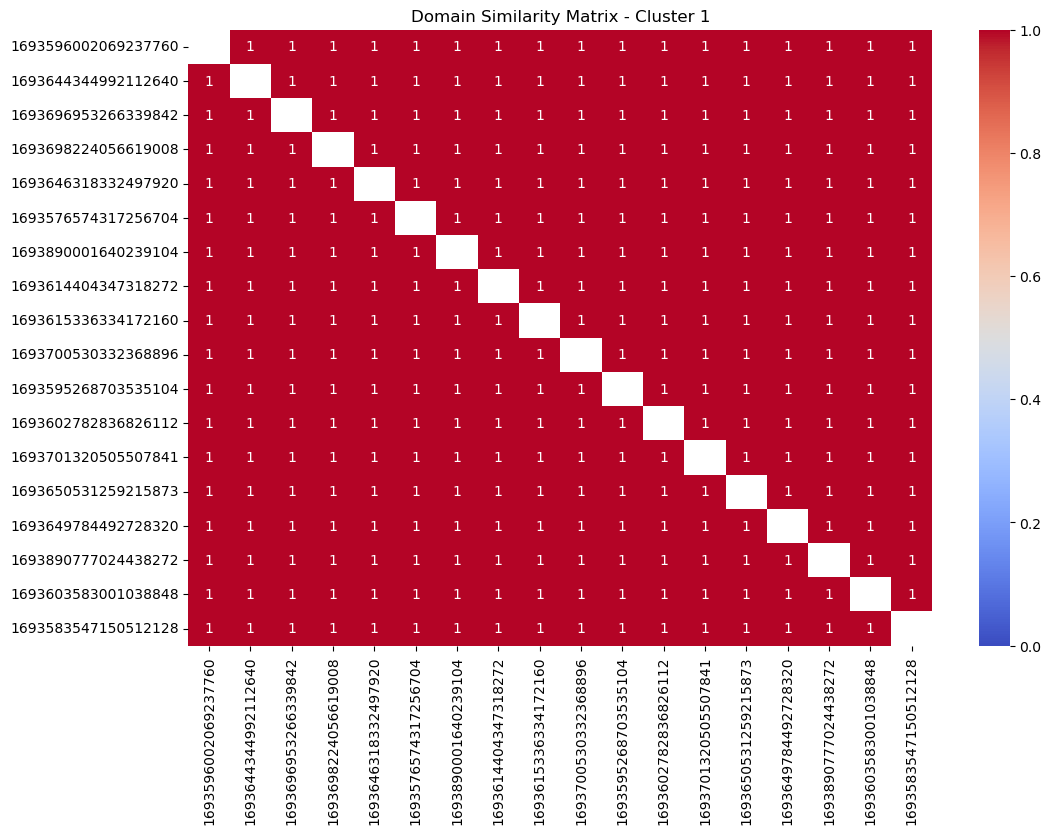

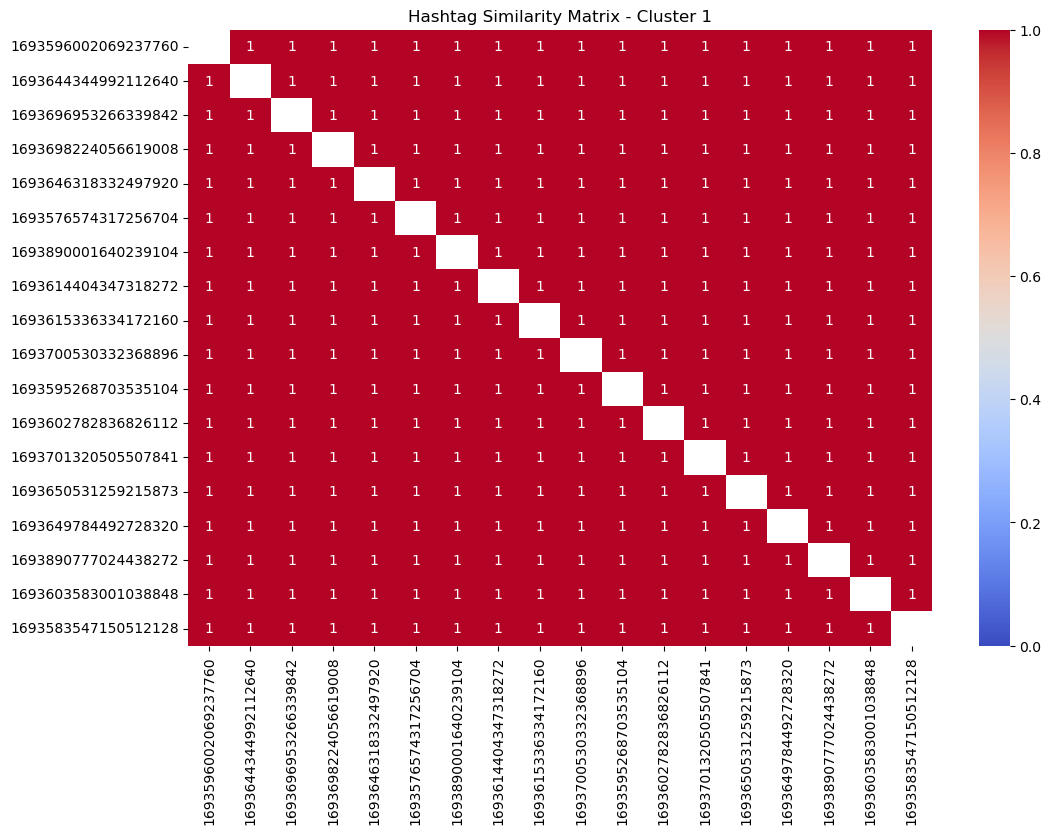

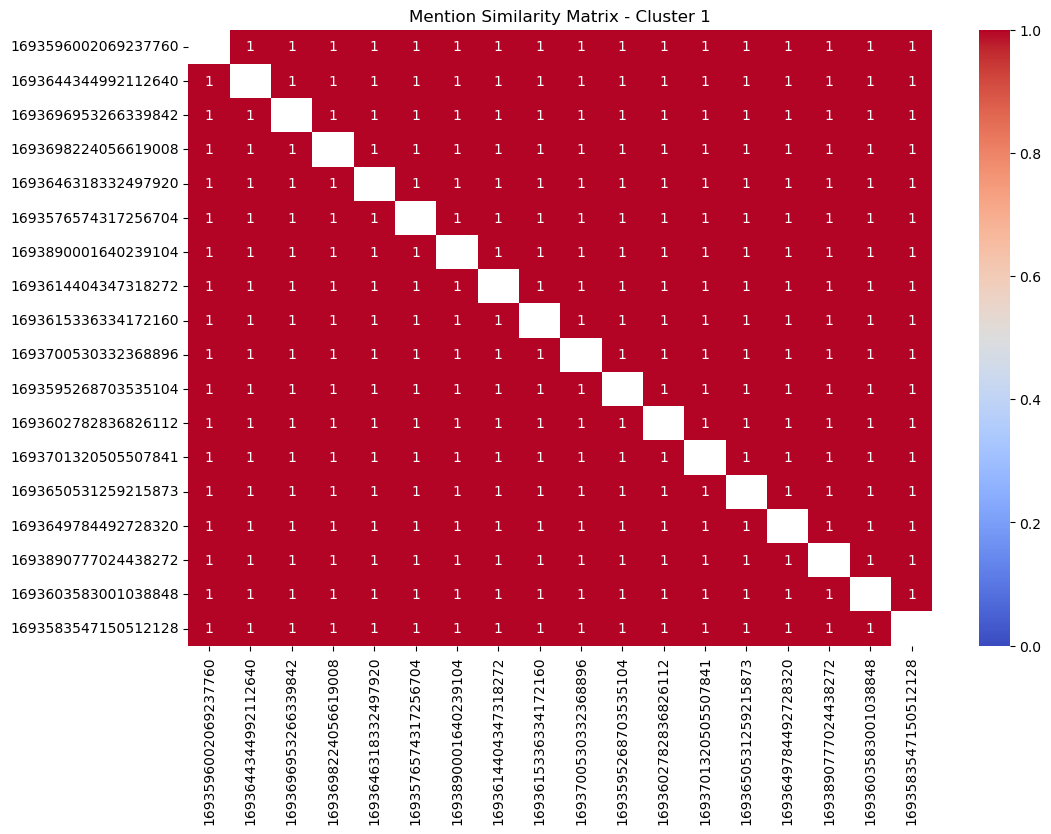

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the input file paths
domains_file = 'domain_info.csv'
hashtags_file = 'hashtag_info.csv'
mentions_file = 'mentions_info.csv'
#clusters_file = 'merged_group_info.csv'
clusters_file = 'auto_users.csv'

def get_user_ids_in_cluster(cluster_number):
    df = pd.read_csv(clusters_file)
    users_in_cluster = df[df['group_id'] == cluster_number]['user_id']
    return users_in_cluster

def get_counts(file_path, user_id, data_type):
    df = pd.read_csv(file_path)
    user_data = df[df['user_id'] == user_id][data_type]
    
    if user_data.empty:
        return None
    
    user_list = set(user_data.values[0].split(', '))
    return user_list

def calculate_similarity(user_list1, user_list2):
    common_items = user_list1.intersection(user_list2)
    count_common_items = len(common_items)
    return count_common_items / max(len(user_list1), len(user_list2))

def create_similarity_matrix(user_ids, file_path, data_type):
    n = len(user_ids)
    similarity_matrix = pd.DataFrame(index=user_ids, columns=user_ids, dtype=float)
    
    for i in range(n):
        for j in range(i + 1, n):
            user_id1 = user_ids[i]
            user_id2 = user_ids[j]
            
            user1_list = get_counts(file_path, user_id1, data_type)
            user2_list = get_counts(file_path, user_id2, data_type)
            
            if user1_list is not None and user2_list is not None:
                similarity = calculate_similarity(user1_list, user2_list)
                similarity_matrix.at[user_id1, user_id2] = similarity
                similarity_matrix.at[user_id2, user_id1] = similarity
    
    return similarity_matrix

def plot_similarity_matrix(matrix, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar=True)
    plt.title(title)
    plt.show()

def visualize_cluster_similarity(cluster_number):
    user_ids = get_user_ids_in_cluster(cluster_number)
    user_ids = user_ids.tolist()
    
    print(f"Calculating similarities for cluster {cluster_number}...")
    
    # Create and plot similarity matrices for domains, hashtags, and mentions
    domain_matrix = create_similarity_matrix(user_ids, domains_file, 'domains')
    hashtag_matrix = create_similarity_matrix(user_ids, hashtags_file, 'hashtags')
    mention_matrix = create_similarity_matrix(user_ids, mentions_file, 'mentions')
    
    plot_similarity_matrix(domain_matrix, f'Domain Similarity Matrix - Cluster {cluster_number}')
    plot_similarity_matrix(hashtag_matrix, f'Hashtag Similarity Matrix - Cluster {cluster_number}')
    plot_similarity_matrix(mention_matrix, f'Mention Similarity Matrix - Cluster {cluster_number}')

# Example usage
cluster_number = int(input("Enter the cluster number: "))
visualize_cluster_similarity(cluster_number)


In [50]:
import pandas as pd

# Define the paths to the CSV files
#auto_users_file = 'auto_users.csv'
auto_users_file = 'merged_group_info.csv'
hashtag_info_file = 'hashtag_info.csv'

# Load the grouped data
auto_users_df = pd.read_csv(auto_users_file)

# Filter users with group_id 2
users_group_2 = auto_users_df[auto_users_df['group_id'] == 1]['user_id'].astype(str).tolist()

# Load hashtag information
hashtag_info_df = pd.read_csv(hashtag_info_file)

# Ensure the hashtag_info.csv has the necessary columns
if 'user_id' not in hashtag_info_df.columns or 'hashtags' not in hashtag_info_df.columns:
    raise ValueError("The hashtag_info.csv file must contain 'user_id' and 'hashtags' columns.")

# Filter hashtag information for users in group_id 2
hashtag_info_group_2 = hashtag_info_df[hashtag_info_df['user_id'].astype(str).isin(users_group_2)]

# Display the result
display(hashtag_info_group_2)


user_id                                           hashtags
570  1690656917339922432  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
571  1690660534994280448  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
573  1692425618527555584  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
576  1692489033728057346  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
577  1692490408931241984  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
578  1692846214633701376  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
579  1692851403440701440  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
581  1692858323274756097  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
584  1693576574317256704  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
585  1693583547150512128  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
586  1693595268703535104  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
587  1693596002069237760  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
588  1693602782836826112  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
589  1693603583001038848  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
590  1693614404347318272  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
591  1693615336334172160  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
592  1693644344992112640  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
593  1693646318332497920  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
594  1693649784492728320  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
595  1693650531259215873  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
596  1693696953266339842  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
597  1693698224056619008  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
598  1693700530332368896  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
599  1693701320505507841  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
600  1693890001640239104  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...
601  1693890777024438272  #AntiPakistan, #Beware, #FakeNewsAlert, #Gilgi...

In [46]:
import pandas as pd

# Define the paths to the CSV files
#auto_users_file = 'auto_users.csv'
auto_users_file = 'merged_group_info.csv'
domain_info_file = 'domain_info.csv'
hashtag_info_file = 'hashtag_info.csv'
mentions_info_file = 'mentions_info.csv'
output_html_file = 'combined_info.html'

# Define the group IDs to filter
group_ids_to_filter = [6,7,8,9]

# Load the grouped data
auto_users_df = pd.read_csv(auto_users_file)

# Filter users with the specified group IDs
users_filtered = auto_users_df[auto_users_df['group_id'].isin(group_ids_to_filter)]

# Load domain information
domain_info_df = pd.read_csv(domain_info_file)
if 'user_id' not in domain_info_df.columns or 'domains' not in domain_info_df.columns:
    raise ValueError("The domain_info.csv file must contain 'user_id' and 'domains' columns.")
domain_info_df = domain_info_df[domain_info_df['user_id'].astype(str).isin(users_filtered['user_id'].astype(str))]

# Load hashtag information
hashtag_info_df = pd.read_csv(hashtag_info_file)
if 'user_id' not in hashtag_info_df.columns or 'hashtags' not in hashtag_info_df.columns:
    raise ValueError("The hashtag_info.csv file must contain 'user_id' and 'hashtags' columns.")
hashtag_info_df = hashtag_info_df[hashtag_info_df['user_id'].astype(str).isin(users_filtered['user_id'].astype(str))]

# Load mentions information
mentions_info_df = pd.read_csv(mentions_info_file)
if 'user_id' not in mentions_info_df.columns or 'mentions' not in mentions_info_df.columns:
    raise ValueError("The mentions_info.csv file must contain 'user_id' and 'mentions' columns.")
mentions_info_df = mentions_info_df[mentions_info_df['user_id'].astype(str).isin(users_filtered['user_id'].astype(str))]

# Merge domain, hashtag, and mention information with the filtered users DataFrame
combined_df = users_filtered.copy()

# Merge domain information
combined_df = pd.merge(combined_df, domain_info_df[['user_id', 'domains']], on='user_id', how='left')

# Merge hashtag information
combined_df = pd.merge(combined_df, hashtag_info_df[['user_id', 'hashtags']], on='user_id', how='left')

# Merge mentions information
combined_df = pd.merge(combined_df, mentions_info_df[['user_id', 'mentions']], on='user_id', how='left')

# Remove the 'week_vector' column if it exists
if 'week_vector' in combined_df.columns:
    combined_df = combined_df.drop(columns=['week_vector'])

# Sort by 'group_id'
combined_df = combined_df.sort_values(by='group_id')

# Save the combined data to an HTML file
combined_df.to_html(output_html_file, index=False)

print(f"Combined information saved to {output_html_file}")


Combined information saved to combined_info.html


In [ ]:
import pandas as pd

# Define the file paths
hashtag_info_file = 'hashtag_info.csv'
auto_users_file = 'auto_users.csv'

# Load hashtag information
hashtag_info_df = pd.read_csv(hashtag_info_file)

# Load auto_users to get screen_name
auto_users_df = pd.read_csv(auto_users_file)

# Check if the necessary columns exist
if 'user_id' not in hashtag_info_df.columns or 'hashtags' not in hashtag_info_df.columns:
    raise ValueError("The hashtag_info.csv file must contain 'user_id' and 'hashtags' columns.")

# Filter for rows where 'hashtags' contains 'AntiPakistan'
filtered_df = hashtag_info_df[hashtag_info_df['hashtags'].str.contains('AntiPakistan', na=False)]

# Merge filtered hashtag info with auto_users to include screen_name and group_id
merged_df = pd.merge(filtered_df, auto_users_df[['user_id', 'screen_name', 'group_id']], on='user_id', how='left')

# Sort by group_id and user_id
merged_df = merged_df.sort_values(by=['group_id', 'user_id'])

# Set pandas display options to show full DataFrame
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column

# Display the result
print(merged_df[['user_id', 'screen_name', 'group_id', 'hashtags']])

# Save the output to an HTML file
html_output_file = 'filtered_hashtags_output.html'
merged_df.to_html(html_output_file, index=False)

print(f"Output saved to {html_output_file}")


In [6]:
import pandas as pd

# Define file paths
hashtag_info_file = 'hashtag_info.csv'
domain_info_file = 'domain_info.csv'
mentions_info_file = 'mentions_info.csv'
group_info_file = 'auto_users.csv'

# Load the hashtag, domain, mentions, and group info
hashtag_df = pd.read_csv(hashtag_info_file)
domain_df = pd.read_csv(domain_info_file)
mentions_df = pd.read_csv(mentions_info_file)
group_df = pd.read_csv(group_info_file)

# Function to calculate similarity between two sets (generic for hashtags, domains, mentions)
def calculate_similarity(set1, set2):
    common_items = set1.intersection(set2)
    return len(common_items) / max(len(set1), len(set2))

# Function to get unique items (hashtags, domains, mentions) for each group
def get_group_items(group_id, data_df, group_df, column_name):
    user_ids = group_df[group_df['group_id'] == group_id]['user_id']
    group_items = set()

    for user_id in user_ids:
        items_str = data_df[data_df['user_id'] == user_id][column_name].values
        if len(items_str) > 0 and isinstance(items_str[0], str):
            items = set(items_str[0].split(', '))
            group_items.update(items)

    return group_items

# Create dictionaries to store group-wise hashtags, domains, and mentions
group_hashtags = {}
group_domains = {}
group_mentions = {}

# Populate the dictionaries with items for each group
for group_id in group_df['group_id'].unique():
    group_hashtags[group_id] = get_group_items(group_id, hashtag_df, group_df, 'hashtags')
    group_domains[group_id] = get_group_items(group_id, domain_df, group_df, 'domains')
    group_mentions[group_id] = get_group_items(group_id, mentions_df, group_df, 'mentions')

# Function to merge two groups and log the merge
def merge_groups(group1, group2, group_df, merge_log):
    # Merge group2 into group1 and log it
    group_df.loc[group_df['group_id'] == group2, 'group_id'] = group1
    merge_log.append({'merged_group': group2, 'into_group': group1})
    return group_df

# List to log group merges
merge_log = []

# Iterate over the groups and compare them for merging based on the average similarity
for group1 in group_df['group_id'].unique():
    for group2 in group_df['group_id'].unique():
        if group1 >= group2:
            continue  # Avoid duplicate comparisons

        # Get group-wise hashtags, domains, and mentions
        hashtags_group1 = group_hashtags[group1]
        hashtags_group2 = group_hashtags[group2]
        domains_group1 = group_domains[group1]
        domains_group2 = group_domains[group2]
        mentions_group1 = group_mentions[group1]
        mentions_group2 = group_mentions[group2]

        # Skip if any group has no items to compare
        if len(hashtags_group1) == 0 or len(hashtags_group2) == 0:
            continue
        if len(domains_group1) == 0 or len(domains_group2) == 0:
            continue
        if len(mentions_group1) == 0 or len(mentions_group2) == 0:
            continue

        # Calculate similarity for hashtags, domains, and mentions
        hashtag_similarity = calculate_similarity(hashtags_group1, hashtags_group2)
        domain_similarity = calculate_similarity(domains_group1, domains_group2)
        mention_similarity = calculate_similarity(mentions_group1, mentions_group2)

        # Calculate combined average similarity
        combined_similarity = (hashtag_similarity + domain_similarity + mention_similarity) / 3
        
        # If combined similarity is more than 95%, merge groups
        if combined_similarity > 0.85:
            # Merge into the smaller group_id or based on size
            size_group1 = len(group_df[group_df['group_id'] == group1])
            size_group2 = len(group_df[group_df['group_id'] == group2])

            if size_group1 > size_group2:
                group_df = merge_groups(group1, group2, group_df, merge_log)
            elif size_group1 < size_group2:
                group_df = merge_groups(group2, group1, group_df, merge_log)
            else:
                smaller_group = min(group1, group2)
                larger_group = max(group1, group2)
                group_df = merge_groups(smaller_group, larger_group, group_df, merge_log)

# Convert merge log to a DataFrame
merge_log_df = pd.DataFrame(merge_log)

# Sort the DataFrame by 'group_id'
group_df = group_df.sort_values(by='group_id')

# Save the updated group assignments
output_file = 'merged_group_info.csv'
group_df.to_csv(output_file, index=False)

# Save the merge log
merge_log_file = 'merge_log.csv'
merge_log_df.to_csv(merge_log_file, index=False)

print(f"Updated group assignments saved to {output_file}")
print(f"Merge log saved to {merge_log_file}")


Updated group assignments saved to merged_group_info.csv
Merge log saved to merge_log.csv


In [32]:
import pandas as pd

# Define the path to the CSV file
#auto_users_file = 'auto_users.csv'
auto_users_file = 'merged_group_info.csv'

# Load the grouped data
grouped_df = pd.read_csv(auto_users_file)

# Count the number of users in each group
user_counts = grouped_df.groupby('group_id')['user_id'].count().reset_index()

# Rename columns for clarity
user_counts.columns = ['group_id', 'user_count']

# Save the DataFrame to an HTML file
html_file = 'user_counts.html'
user_counts.to_html(html_file, index=False)

# Display a message with the file path
print(f"DataFrame saved to {html_file}. Open this file in a browser to view the full contents.")


DataFrame saved to user_counts.html. Open this file in a browser to view the full contents.


In [7]:
import pandas as pd
import json
import os

# Load the CSV file
df = pd.read_csv('merged_group_info.csv')

# Define the path to the user tweets directory
user_tweets_dir = 'user_tweets'

# Create a dictionary to store SenderProfileLink information
user_tweet_data = {}

# Get the user IDs from the DataFrame
user_ids = df['user_id'].tolist()

for user_id in user_ids:
    json_file_path = os.path.join(user_tweets_dir, f'user_{user_id}.json')
    
    if os.path.exists(json_file_path):
        with open(json_file_path, 'r') as file:
            tweet_data = json.load(file)
            
            # Extract the first tweet's SenderProfileLink
            if tweet_data and len(tweet_data) > 0:
                first_tweet = tweet_data[0]
                sender_profile_link = first_tweet.get('SenderProfileLink')
                user_tweet_data[user_id] = sender_profile_link

# Add SenderProfileLink to the DataFrame
df['SenderProfileLink'] = df['user_id'].map(user_tweet_data)

# Save the updated DataFrame to a new CSV file
output_file = 'merged_group_info.csv'
df.to_csv(output_file, index=False)

print(f"Updated group information with SenderProfileLink saved to {output_file}")


Updated group information with SenderProfileLink saved to merged_group_info.csv


In [41]:
import pandas as pd
from collections import Counter

# Define file paths
hashtag_info_file = 'hashtag_info.csv'
output_csv_file = 'top_100_hashtags.csv'

# Load the hashtag information
hashtag_df = pd.read_csv(hashtag_info_file)

# Check if required columns exist
if 'hashtags' not in hashtag_df.columns:
    raise ValueError("The hashtag_info.csv file must contain 'hashtags' column.")

# Extract and concatenate all hashtags
all_hashtags = []
for hashtags_str in hashtag_df['hashtags'].dropna():
    hashtags = hashtags_str.split(', ')
    all_hashtags.extend(hashtags)

# Count occurrences of each hashtag
hashtag_counts = Counter(all_hashtags)

# Convert to DataFrame for easier handling
hashtag_counts_df = pd.DataFrame(hashtag_counts.items(), columns=['hashtag', 'count'])

# Sort by count in descending order and get top 100
top_hashtags_df = hashtag_counts_df.sort_values(by='count', ascending=False).head(100)

# Save the top 100 hashtags to CSV
top_hashtags_df.to_csv(output_csv_file, index=False)

print(f"Top 100 hashtags saved to {output_csv_file}")


Top 100 hashtags saved to top_100_hashtags.csv


In [42]:
import pandas as pd

# Define file paths
group_info_file = 'merged_group_info.csv'
hashtag_info_file = 'hashtag_info.csv'

# Load the group and hashtag information
group_df = pd.read_csv(group_info_file)
hashtag_df = pd.read_csv(hashtag_info_file)

# Define categories and their associated hashtags
categories = {
    'Pro India': {'#IndianArmy', '#India', '#IndiaArmy', '#HarGharTiranga','#Haridwar',},
    'Kashmir':{'#Kashmir','#BadaltaKashmir','Article370','#GlobalKashmir'},
    'Anti Pakistan': {'#AntiPakistan', '#GilgitBaltistanWantsBharat', '#GilgitBaltistan',},
    'Anti China': {'#China','#Chinese','#CCP','#ChinaTaiwan'}
}

# Function to get hashtags for a group
def get_group_hashtags(group_id, hashtag_df, group_df):
    user_ids = group_df[group_df['group_id'] == group_id]['user_id']
    group_hashtags = set()
    
    for user_id in user_ids:
        hashtags_str = hashtag_df[hashtag_df['user_id'] == user_id]['hashtags'].values
        if len(hashtags_str) > 0 and isinstance(hashtags_str[0], str):
            hashtags = set(hashtags_str[0].split(', '))
            group_hashtags.update(hashtags)
    
    return group_hashtags

# Function to categorize a group's hashtags
def categorize_group(hashtags):
    hashtags_set = set(hashtags.split(', '))
    matched_categories = []

    for category, keywords in categories.items():
        if hashtags_set & keywords:  # Check if there's any intersection
            matched_categories.append(category)
    
    return ', '.join(matched_categories) if matched_categories else 'Uncategorized'

# Create a DataFrame to store categorized information
categorized_df = group_df.copy()

# Get unique group IDs
group_ids = group_df['group_id'].unique()

# Categorize each group
group_categories = []
for group_id in group_ids:
    hashtags = get_group_hashtags(group_id, hashtag_df, group_df)
    category = categorize_group(', '.join(hashtags))
    group_categories.append({'group_id': group_id, 'categories': category})

# Convert to DataFrame
category_df = pd.DataFrame(group_categories)

# Merge with original group info
final_df = pd.merge(group_df, category_df, on='group_id', how='left')

# Save the categorized data
output_file = 'group_info_with_categories.csv'
final_df.to_csv(output_file, index=False)

print(f"Categorized group information saved to {output_file}")


Categorized group information saved to group_info_with_categories.csv


In [1]:
import pandas as pd

# Define file paths
merged_group_info_file = 'merged_group_info.csv'
group_info_with_categories_file = 'group_info_with_categories.csv'
output_html_file = 'merged_group_info_with_categories.html'

# Load the CSV files
merged_group_df = pd.read_csv(merged_group_info_file)
group_categories_df = pd.read_csv(group_info_with_categories_file)

# Merge the DataFrames based on 'user_id' to add 'categories' to 'merged_group_info'
# Assuming 'user_id' is a common column in both DataFrames
merged_df = pd.merge(merged_group_df, group_categories_df[['user_id', 'categories']], on='user_id', how='left')

# Remove 'week_vector' column if it exists
if 'week_vector' in merged_df.columns:
    merged_df = merged_df.drop(columns=['week_vector'])

# Make 'SenderProfileLink' clickable
merged_df['SenderProfileLink'] = merged_df['SenderProfileLink'].apply(
    lambda x: f'<a href="{x}" target="_blank">{x}</a>' if pd.notna(x) else 'N/A'
)

# Save the updated DataFrame to an HTML file
merged_df.to_html(output_html_file, index=False, escape=False)

print(f"Combined and updated information saved to {output_html_file}")


Combined and updated information saved to merged_group_info_with_categories.html


In [4]:
merged_df.to_csv('merged_group_info_with_categories.csv', index=False)


In [12]:
import pandas as pd

# Load the merged group info DataFrame
merged_df = pd.read_csv('merged_group_info_with_categories.csv')  # Update with the correct path

# Count unique groups in the 'group_id' column
unique_groups_count = merged_df['group_id'].nunique()
print(f'Number of unique groups: {unique_groups_count}')


Number of unique groups: 219


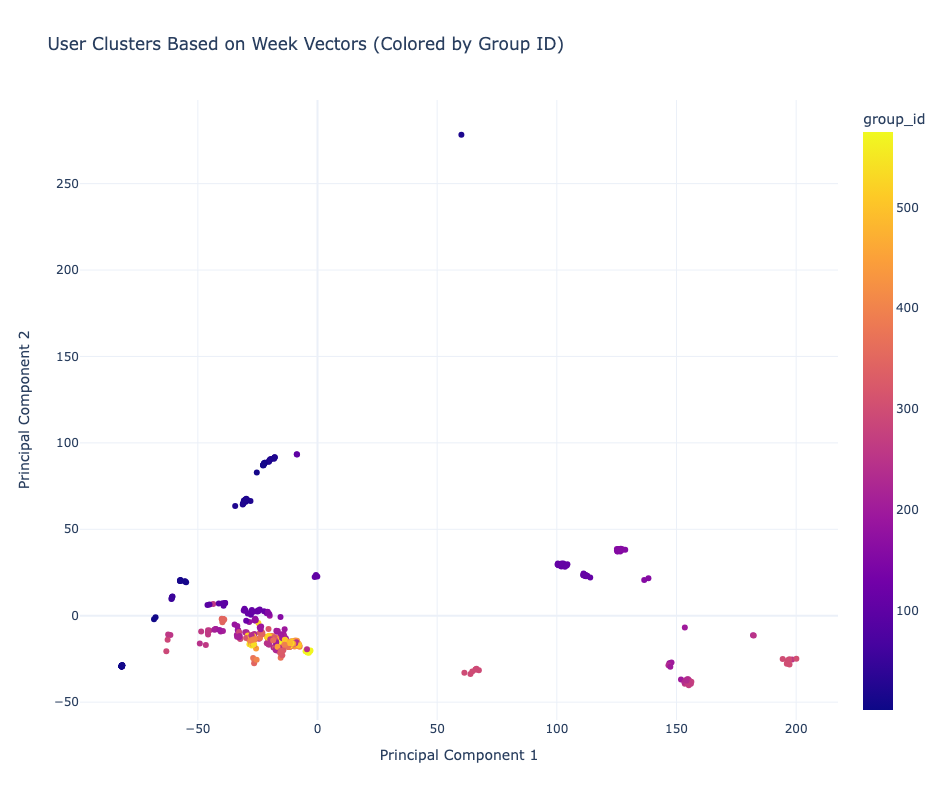

In [11]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA

# Load the filtered_week_vector_output.csv file
week_vector_df = pd.read_csv('filtered_week_vector_output.csv')

# Load the merged group info (from your earlier DataFrame)
merged_df = pd.read_csv('merged_group_info_with_categories.csv')

# Ensure 'week_vector' is converted to a list if needed
week_vector_df['week_vector'] = week_vector_df['week_vector'].apply(eval)

# Merge the week vector DataFrame with the merged DataFrame based on 'user_id'
combined_df = pd.merge(week_vector_df, merged_df, on='user_id', how='left')

# Extract the week vectors for dimensionality reduction
week_vectors = pd.DataFrame(combined_df['week_vector'].to_list())

# Apply PCA to reduce week vectors to 2 components for visualization
pca = PCA(n_components=2)
combined_df[['pc1', 'pc2']] = pca.fit_transform(week_vectors)

# Create a scatter plot where each point represents a user, colored by 'group_id'
fig = px.scatter(
    combined_df, 
    x='pc1', 
    y='pc2', 
    color='group_id',  # Color points by 'group_id'
    hover_data={
        'screen_name_x': True,
        'group_id': True,
        'SenderProfileLink': True,
        'categories': True
    },
    title='User Clusters Based on Week Vectors (Colored by Group ID)',
    labels={'pc1': 'Principal Component 1', 'pc2': 'Principal Component 2'},
    template='plotly_white'
)

# Increase the size of the plot
fig.update_layout(
    width=1200,  # Set the desired width
    height=800   # Set the desired height
)

# Make 'SenderProfileLink' clickable in hover data
combined_df['SenderProfileLink'] = combined_df['SenderProfileLink'].apply(
    lambda x: f'<a href="{x}" target="_blank">{x}</a>' if pd.notna(x) else 'N/A'
)

# Show the plot
fig.show()


In [14]:
import pandas as pd

# Define file paths
hashtag_info_file = 'hashtag_info.csv'
domain_info_file = 'domain_info.csv'
mentions_info_file = 'mentions_info.csv'
group_info_file = 'auto_users.csv'

# Load the hashtag, domain, mentions, and group info
hashtag_df = pd.read_csv(hashtag_info_file)
domain_df = pd.read_csv(domain_info_file)
mentions_df = pd.read_csv(mentions_info_file)
group_df = pd.read_csv(group_info_file)

# Function to calculate similarity between two sets
def calculate_similarity(set1, set2):
    common_items = set1.intersection(set2)
    return len(common_items) / max(len(set1), len(set2))

# Function to get unique items (hashtags, domains, mentions) for each group
def get_group_items(group_id, data_df, group_df, column_name):
    user_ids = group_df[group_df['group_id'] == group_id]['user_id']
    group_items = set()

    for user_id in user_ids:
        items_str = data_df[data_df['user_id'] == user_id][column_name].values
        if len(items_str) > 0 and isinstance(items_str[0], str):
            items = set(items_str[0].split(', '))
            group_items.update(items)

    return group_items

# Function to merge two groups and log the merge
def merge_groups(group1, group2, group_df, merge_log):
    group_df.loc[group_df['group_id'] == group2, 'group_id'] = group1
    merge_log.append({'merged_group': group2, 'into_group': group1})
    return group_df

# Iterate over thresholds from 95 to 50 in decrements of 5
thresholds = list(range(95, 14, -5))
unique_groups_counts = {}

for threshold in thresholds:
    # Reset the merge log and group assignments
    merge_log = []
    current_group_df = group_df.copy()  # Create a copy to avoid modifying original data

    # Create dictionaries to store group-wise hashtags, domains, and mentions
    group_hashtags = {}
    group_domains = {}
    group_mentions = {}

    # Populate the dictionaries with items for each group
    for group_id in current_group_df['group_id'].unique():
        group_hashtags[group_id] = get_group_items(group_id, hashtag_df, current_group_df, 'hashtags')
        group_domains[group_id] = get_group_items(group_id, domain_df, current_group_df, 'domains')
        group_mentions[group_id] = get_group_items(group_id, mentions_df, current_group_df, 'mentions')

    # Iterate over the groups and compare them for merging based on the average similarity
    for group1 in current_group_df['group_id'].unique():
        for group2 in current_group_df['group_id'].unique():
            if group1 >= group2:
                continue  # Avoid duplicate comparisons

            # Get group-wise hashtags, domains, and mentions
            hashtags_group1 = group_hashtags[group1]
            hashtags_group2 = group_hashtags[group2]
            domains_group1 = group_domains[group1]
            domains_group2 = group_domains[group2]
            mentions_group1 = group_mentions[group1]
            mentions_group2 = group_mentions[group2]

            # Skip if any group has no items to compare
            if len(hashtags_group1) == 0 or len(hashtags_group2) == 0:
                continue
            if len(domains_group1) == 0 or len(domains_group2) == 0:
                continue
            if len(mentions_group1) == 0 or len(mentions_group2) == 0:
                continue

            # Calculate similarity for hashtags, domains, and mentions
            hashtag_similarity = calculate_similarity(hashtags_group1, hashtags_group2)
            domain_similarity = calculate_similarity(domains_group1, domains_group2)
            mention_similarity = calculate_similarity(mentions_group1, mentions_group2)

            # Calculate combined average similarity
            combined_similarity = (hashtag_similarity + domain_similarity + mention_similarity) / 3
            
            # If combined similarity is more than the threshold, merge groups
            if combined_similarity > (threshold / 100):  # Convert threshold to decimal
                # Merge into the smaller group_id or based on size
                size_group1 = len(current_group_df[current_group_df['group_id'] == group1])
                size_group2 = len(current_group_df[current_group_df['group_id'] == group2])

                if size_group1 > size_group2:
                    current_group_df = merge_groups(group1, group2, current_group_df, merge_log)
                elif size_group1 < size_group2:
                    current_group_df = merge_groups(group2, group1, current_group_df, merge_log)
                else:
                    smaller_group = min(group1, group2)
                    larger_group = max(group1, group2)
                    current_group_df = merge_groups(smaller_group, larger_group, current_group_df, merge_log)

    # Store the number of unique groups after merging
    unique_groups_counts[threshold] = current_group_df['group_id'].nunique()

# Print the results
for threshold, count in unique_groups_counts.items():
    print(f"Threshold: {threshold}%, Unique Groups: {count}")


Threshold: 95%, Unique Groups: 429
Threshold: 90%, Unique Groups: 371
Threshold: 85%, Unique Groups: 219
Threshold: 80%, Unique Groups: 131
Threshold: 75%, Unique Groups: 74
Threshold: 70%, Unique Groups: 51
Threshold: 65%, Unique Groups: 37
Threshold: 60%, Unique Groups: 27
Threshold: 55%, Unique Groups: 21
Threshold: 50%, Unique Groups: 14
Threshold: 45%, Unique Groups: 11
Threshold: 40%, Unique Groups: 7
Threshold: 35%, Unique Groups: 6
Threshold: 30%, Unique Groups: 5
Threshold: 25%, Unique Groups: 5
Threshold: 20%, Unique Groups: 5
Threshold: 15%, Unique Groups: 5


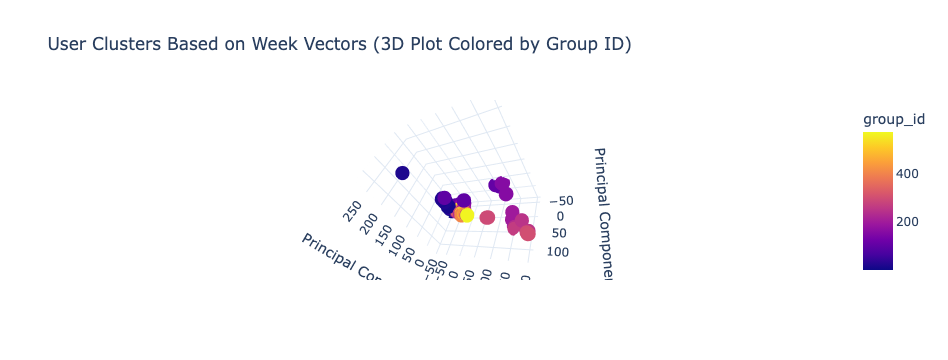

In [10]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA

# Load the filtered_week_vector_output.csv file
week_vector_df = pd.read_csv('filtered_week_vector_output.csv')

# Load the merged group info (from your earlier DataFrame)
merged_df = pd.read_csv('merged_group_info_with_categories.csv')

# Ensure 'week_vector' is converted to a list if needed
week_vector_df['week_vector'] = week_vector_df['week_vector'].apply(eval)

# Merge the week vector DataFrame with the merged DataFrame based on 'user_id'
# Assuming 'user_id' is present in both DataFrames
combined_df = pd.merge(week_vector_df, merged_df, on='user_id', how='left')

# Extract the week vectors for dimensionality reduction
week_vectors = pd.DataFrame(combined_df['week_vector'].to_list())

# Apply PCA to reduce week vectors to 3 components for 3D visualization
pca = PCA(n_components=3)
combined_df[['pc1', 'pc2', 'pc3']] = pca.fit_transform(week_vectors)

# Create a 3D scatter plot where each point represents a user, colored by 'group_id'
fig = px.scatter_3d(
    combined_df, 
    x='pc1', 
    y='pc2', 
    z='pc3', 
    color='group_id',  # Color points by 'group_id'
    hover_data={
        'screen_name_x': True,  # Use the correct column name
        'group_id': True,
        'SenderProfileLink': True,
        'categories': True
    },
    title='User Clusters Based on Week Vectors (3D Plot Colored by Group ID)',
    labels={'pc1': 'Principal Component 1', 'pc2': 'Principal Component 2', 'pc3': 'Principal Component 3'},
    template='plotly_white'
)

# Make 'SenderProfileLink' clickable in hover data
combined_df['SenderProfileLink'] = combined_df['SenderProfileLink'].apply(
    lambda x: f'<a href="{x}" target="_blank">{x}</a>' if pd.notna(x) else 'N/A'
)

# Show the 3D plot
fig.show()


Enter the cluster numbers separated by commas:  1


Calculating similarities for combined clusters: [1]...


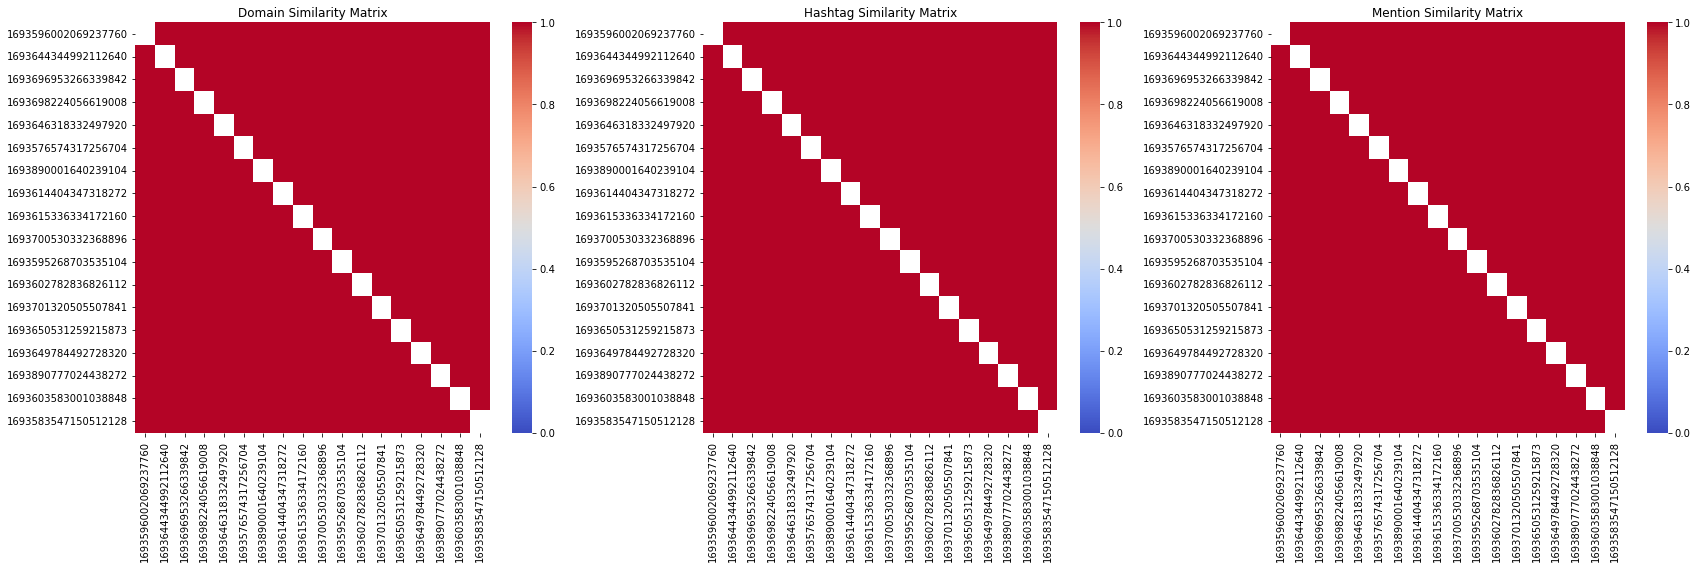

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the input file paths
domains_file = 'domain_info.csv'
hashtags_file = 'hashtag_info.csv'
mentions_file = 'mentions_info.csv'
#clusters_file = 'merged_group_info.csv'
clusters_file = 'auto_users.csv'

def get_user_ids_in_clusters(cluster_numbers):
    df = pd.read_csv(clusters_file)
    users_in_clusters = df[df['group_id'].isin(cluster_numbers)]['user_id']
    return users_in_clusters

def get_counts(file_path, user_id, data_type):
    df = pd.read_csv(file_path)
    user_data = df[df['user_id'] == user_id][data_type]
    
    if user_data.empty:
        return None
    
    user_list = set(user_data.values[0].split(', '))
    return user_list

def calculate_similarity(user_list1, user_list2):
    common_items = user_list1.intersection(user_list2)
    count_common_items = len(common_items)
    return count_common_items / max(len(user_list1), len(user_list2))

def create_similarity_matrix(user_ids, file_path, data_type):
    n = len(user_ids)
    similarity_matrix = pd.DataFrame(index=user_ids, columns=user_ids, dtype=float)
    
    for i in range(n):
        for j in range(i + 1, n):
            user_id1 = user_ids[i]
            user_id2 = user_ids[j]
            
            user1_list = get_counts(file_path, user_id1, data_type)
            user2_list = get_counts(file_path, user_id2, data_type)
            
            if user1_list is not None and user2_list is not None:
                similarity = calculate_similarity(user1_list, user2_list)
                similarity_matrix.at[user_id1, user_id2] = similarity
                similarity_matrix.at[user_id2, user_id1] = similarity
    
    return similarity_matrix

def plot_combined_similarity_matrix(domain_matrix, hashtag_matrix, mention_matrix):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    sns.heatmap(domain_matrix, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[0], cbar=True)
    axes[0].set_title('Domain Similarity Matrix')

    sns.heatmap(hashtag_matrix, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[1], cbar=True)
    axes[1].set_title('Hashtag Similarity Matrix')

    sns.heatmap(mention_matrix, annot=False, cmap='coolwarm', vmin=0, vmax=1, ax=axes[2], cbar=True)
    axes[2].set_title('Mention Similarity Matrix')

    plt.tight_layout()
    plt.show()

def visualize_combined_cluster_similarity(cluster_numbers):
    user_ids = get_user_ids_in_clusters(cluster_numbers)
    user_ids = user_ids.tolist()
    
    print(f"Calculating similarities for combined clusters: {cluster_numbers}...")

    # Create combined similarity matrices for domains, hashtags, and mentions
    domain_matrix = create_similarity_matrix(user_ids, domains_file, 'domains')
    hashtag_matrix = create_similarity_matrix(user_ids, hashtags_file, 'hashtags')
    mention_matrix = create_similarity_matrix(user_ids, mentions_file, 'mentions')

    # Plot the combined similarity matrices
    plot_combined_similarity_matrix(domain_matrix, hashtag_matrix, mention_matrix)

# Example usage
cluster_input = input("Enter the cluster numbers separated by commas: ")
cluster_numbers = list(map(int, cluster_input.split(',')))
visualize_combined_cluster_similarity(cluster_numbers)


In [ ]:
import pandas as pd
from itertools import combinations

# Define file paths
hashtag_info_file = 'hashtag_info.csv'
auto_users_file = 'auto_users.csv'

# Load hashtag information
hashtag_info_df = pd.read_csv(hashtag_info_file)

# Load auto_users to get screen_name and group_id
auto_users_df = pd.read_csv(auto_users_file)

# Check if necessary columns exist
if 'user_id' not in hashtag_info_df.columns or 'hashtags' not in hashtag_info_df.columns:
    raise ValueError("The hashtag_info.csv file must contain 'user_id' and 'hashtags' columns.")

# Convert hashtags column to sets for easier comparison
hashtag_info_df['hashtag_set'] = hashtag_info_df['hashtags'].apply(lambda x: set(x.split(',')) if pd.notna(x) else set())

# Function to calculate similarity percentage between two sets of hashtags
def calculate_similarity(set1, set2):
    if not set1 or not set2:
        return 0
    intersection = len(set1.intersection(set2))
    return intersection / max(len(set1), len(set2))

# Create a list to store matched users
matched_users = []

# Compare each pair of users and check for similarity greater than 80%
for (user1, hashtags1), (user2, hashtags2) in combinations(hashtag_info_df[['user_id', 'hashtag_set']].values, 2):
    similarity = calculate_similarity(hashtags1, hashtags2)
    if similarity >= 0.8:
        matched_users.append({'user1_id': user1, 'user2_id': user2, 'similarity': similarity})

# Convert to DataFrame
matched_users_df = pd.DataFrame(matched_users)

# Merge with auto_users to get screen_name and group_id for both users
matched_users_df = pd.merge(matched_users_df, auto_users_df[['user_id', 'screen_name', 'group_id']],
                            left_on='user1_id', right_on='user_id', how='left').drop(columns='user_id')
matched_users_df = pd.merge(matched_users_df, auto_users_df[['user_id', 'screen_name', 'group_id']],
                            left_on='user2_id', right_on='user_id', how='left', suffixes=('_user1', '_user2')).drop(columns='user_id')

# Sort by similarity for easier viewing
matched_users_df = matched_users_df.sort_values(by='similarity', ascending=False)

# Display the result
print(matched_users_df[['user1_id', 'screen_name_user1', 'group_id_user1', 'user2_id', 'screen_name_user2', 'group_id_user2', 'similarity']])

# Save the result to an HTML file
html_output_file = 'del_hashtag_similarity_output.html'
matched_users_df.to_html(html_output_file, index=False)

print(f"Output saved to {html_output_file}")
